In [1]:
import folium
import pandas as pd
import json
import numpy as np

In [2]:
virus_file = "./data/West_Nile_Virus_by_County.json"
virusdf = pd.read_json(virus_file).set_index('County')

In [3]:
county_geo = r'./data/jsoncounties-CA.min.js'

with open (county_geo, 'r') as inputs:
    for i in inputs:
        counties = json.loads(i)

In [4]:
# get the geo dictionary in the right format
def assemble(counties):
    if "properties" in counties["features"]:
        del counties["features"]["properties"]

    features = {}
    features['type'] = counties['type']
    features['features'] = []

    for c in counties['features']["counties"]:
        row = {"id":c["name"],
               "type":"Feature",
               "properties":{"name":c["name"]},
               "geometry":c["geometry"]}
        del row['geometry']['type']
        row['geometry'].update({'type': "MultiPolygon"})
        features['features'].append(row)
        coordinates = []
        
        for f in row['geometry']['coordinates']:
            coordinates.append(f)

        del row['geometry']['coordinates']
        row['geometry'].update({'coordinates':[coordinates]})

    return features

In [5]:
features = assemble(counties)

In [6]:
virusdf.reset_index(inplace=True)

In [7]:
virus_by_county = virusdf[["County","Positive_Cases"]].groupby(["County"]).aggregate(np.sum)

In [8]:
virus_by_county.reset_index(inplace=True)

In [9]:
virus_by_year_county = virusdf[["Year","County","Positive_Cases"]].groupby(["Year","County"]).aggregate(np.sum)
#virus_by_year_county

In [10]:
mincount = virus_by_county['Positive_Cases'].min()
maxcount = virus_by_county['Positive_Cases'].max()
step = (maxcount+10)/5
threshold_scale = list(np.arange(maxcount+100,step=int(step)))

In [11]:
fmap = folium.Map(location=[37.5, -118], zoom_start=6)
fmap.choropleth(geo_data=features, data=virus_by_county,
               columns=['County', 'Positive_Cases'],
               key_on='feature.id',
               threshold_scale = threshold_scale,
               fill_color='YlGn',fill_opacity=0.7, line_opacity=0.2,
               legend_name='Positive Cases')

fmap

In [12]:
from bokeh.plotting import figure, show, output_file
from bokeh.sampledata.us_counties import data as counties
from bokeh.io import show
from bokeh.models import ColumnDataSource, HoverTool, LogColorMapper
from bokeh.palettes import Blues6 as palette
from bokeh.plotting import figure

palette.reverse()
import warnings
warnings.filterwarnings("ignore")

In [13]:
included = ["ca"]


counties = {
    code: county for code, county in counties.items() if county["state"] in included
}

county_xs = [county["lons"] for county in counties.values()]
county_ys = [county["lats"] for county in counties.values()]

county_names = [county['name'] for county in counties.values()]
cases_reported = []

for county_id in counties:
    if counties[county_id]["state"] not in included:
        continue
    try:
        countyid = county_id[0] * 1000 + county_id[1]
        cases = virusdf[(virusdf['id'] == countyid)]['Positive_Cases'].sum()
        
        if np.isnan(cases):
            cases = 0
        
        cases_reported.append(cases)
    except KeyError:
        dummy = 1
        
color_mapper = LogColorMapper(palette=palette)

source = ColumnDataSource(data=dict(
    x=county_xs,
    y=county_ys,
    name=county_names,
    cases=cases_reported,
))

TOOLS = "pan,wheel_zoom,reset,hover,save"

p = figure(
    title="California West Nile Virus", tools=TOOLS,
    x_axis_location=None, y_axis_location=None,
    plot_width=1100, plot_height=1000
)

p.grid.grid_line_color = None

p.patches('x', 'y', source=source,
          fill_color={'field': 'cases', 'transform': color_mapper},
          fill_alpha=0.7, line_color="black", line_width=0.5)

hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("Name", "@name"),
    ("Virus cases)", "@cases"),
    ("(Long, Lat)", "($x, $y)"),
]

output_file('cases.html', mode='inline')
show(p)


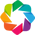

In [14]:
import holoviews as hv
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline

hv.extension('bokeh', 'matplotlib', width="100")
%opts Curve [width=600 height=250 tools=['hover'] ] {+framewise}
%opts Bars  [width=800 height=400 tools=['hover'] legend_position='top_left' xrotation=90]

In [15]:
virus_by_year_county.reset_index(inplace=True)
data = virus_by_year_county.pivot(values='Positive_Cases', columns='County', index='Year')
data.reset_index(inplace=True)
yearly_data = data.groupby('Year').sum().reset_index()
cases = pd.melt(yearly_data, id_vars=['Year'], var_name='County', value_name='Positive_Cases')
cases = cases.fillna(0)

In [16]:
%opts HeatMap [tools=['hover'] colorbar=True](cmap='Blues')
heatmap = hv.HeatMap(cases, label='West Nile Positive Cases Reported')
aggregate = hv.Dataset(heatmap).aggregate('Year', np.mean, np.std)

agg = hv.ErrorBars(aggregate) * hv.Curve(aggregate).opts(plot=dict(xrotation=45))

hm_opts = dict(width=800, height=1000, tools=['hover'], logz=True, invert_yaxis=True,
               xrotation=90, labelled=[], toolbar='above', xaxis=None)

overlay_opts = dict(width=800, height=200, show_title=False)
opts = {'HeatMap': {'plot': hm_opts}, 'Overlay': {'plot': overlay_opts}}
(heatmap + agg).opts(opts).cols(1)

:Layout
   .HeatMap.West_Nile_Positive_Cases_Reported :HeatMap   [Year,County]   (Positive_Cases)
   .Overlay.West_Nile_Positive_Cases_Reported :Overlay
      .ErrorBars.West_Nile_Positive_Cases_Reported :ErrorBars   [Year]   (Positive_Cases,Positive_Cases_std)
      .Curve.West_Nile_Positive_Cases_Reported     :Curve   [Year]   (Positive_Cases,Positive_Cases_std)